In [1]:
print('Kernel Initialized')

Kernel Initialized


In [22]:
# Imports
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from utils import Utils
import plot_utils as plotting
import toml
from sklearn import preprocessing, model_selection, metrics
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("seaborn-v0_8-whitegrid")
#import mplhep as hep
#hep.style.use(hep.style.ATLAS)
from scipy.special import logit, expit
import os

import verstack
import optuna
from iminuit import Minuit
import scipy
import lightgbm

random.seed(42)

In [3]:
config = toml.load('config.toml')
Storage = Utils.HDF5_IO(config['PATHS']['Storage'])

info_features = config['features']['info_features']
B_masses = ['B_mass', 'B_mass_true','B_Bbar_mass_closer_PDG','Bbar_mass','BeeKst_B_mass','BeeKst_Bbar_mass','B_mass_Kstar_mass_closer']


In [4]:
def Data_loader():
    print('Loading MC signal..')
    B_masses = ['B_mass', 'B_mass_true','B_Bbar_mass_closer_PDG','Bbar_mass','BeeKst_B_mass','BeeKst_Bbar_mass','B_mass_Kstar_mass_closer']

    SIG_MC=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['USR'], columns=None, use_threads=True, storage_options=None)
    SIG_MC = SIG_MC.query(Utils.selection_cuts()['usr_lowq2'])
    SIG_MC.drop(SIG_MC[~((SIG_MC.BeeKst_isTrueNonresBd==1) | (SIG_MC.BeeKst_isTrueNonresBdbar==1))].index,inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBd==1)].index[config['ML_config']['N_Signal']['Bd']:],inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBdbar==1)].index[config['ML_config']['N_Signal']['BdBar']:],inplace=True)

    

    label = (SIG_MC.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (SIG_MC.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]

    #SIG_MC=SIG_MC.drop(columns=info_features)
    #SIG_MC=SIG_MC.drop(columns=B_masses)
    print('Colomns of only on value is removed..')
    SIG_MC=SIG_MC.drop(SIG_MC.std()[(SIG_MC.std() == 0)].index, axis=1)
    print('Dublecates is removed..')
    SIG_MC=SIG_MC.loc[:,~SIG_MC.T.duplicated(keep='last')]
    SIG_MC['label'] = label
    SIG_MC['label'].astype(int)

    

    print('Loading background sidebands..')
    BKG_SB=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SB'], columns=None, use_threads=True, storage_options=None)
    BKG_SB = BKG_SB.query(Utils.selection_cuts()['nn1trb_lowq2'])
    BKG_SB.drop(BKG_SB.index[config['ML_config']['N_background']:],inplace=True)
    label = (BKG_SB.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (BKG_SB.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]
    BKG_SB['label'] = label
    BKG_SB['label'].astype(int)

    print('Loading background signal region..')
    BKG_SR=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SR'], columns=None, use_threads=True, storage_options=None)
    BKG_SR = BKG_SR.query(Utils.selection_cuts()['nn2trb_lowq2'])
    BKG_SR.drop(BKG_SR.index[config['ML_config']['N_background']:],inplace=True)
    label = (BKG_SR.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (BKG_SR.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]
    BKG_SR['label'] = label
    BKG_SR['label'].astype(int)

    print('Loading MC background..')
    BKG_MC=pd.read_feather(path=config['train_files']['Bkg_MC'], columns=None, use_threads=True, storage_options=None)
    BKG_MC = BKG_MC.query(Utils.selection_cuts()['main'])
    BKG_MC.info_sample = 'BKG_MC'
    label = (BKG_MC.info_sample == 0)*0
    for i in config['labels Sig_VS_Bkg']:
        label += (BKG_MC.info_sample == str(i))*config['labels Sig_VS_Bkg'][str(i)]
    BKG_MC['label'] = label
    BKG_MC['label'].astype(int)


    # Generate tests..
    print('Loading tests..')
    BKG_MC_test=pd.read_feather(path=config['train_files']['Bkg_MC'], columns=None, use_threads=True, storage_options=None)
    BKG_MC_test = BKG_MC_test.query(Utils.selection_cuts()['main'])
    BKG_MC_test.info_sample = 'BKG_MC_test'
    BKG_MC_test['label'] = 1


    BKG_SB_test=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SB'], columns=None, use_threads=True, storage_options=None)
    BKG_SB_test = BKG_SB_test.query(Utils.selection_cuts()['nn1trb_lowq2'])
    BKG_SB_test.drop(BKG_SB_test.index[len(BKG_MC_test):],inplace=True)
    BKG_SB_test['label'] = 0

    BKG_SR_test=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['SR'], columns=None, use_threads=True, storage_options=None)
    BKG_SR_test = BKG_SR_test.query(Utils.selection_cuts()['nn2trb_lowq2'])
    BKG_SR_test.drop(BKG_SR_test.index[len(BKG_MC_test):],inplace=True)
    BKG_SR_test['label'] = 0


    return SIG_MC, BKG_SB, BKG_SR, BKG_MC, {'SB':BKG_SB_test, 'SR': BKG_SR_test, 'MC': BKG_MC_test }

SIG_MC, BKG_SB, BKG_SR, BKG_MC, MC_tests = Data_loader()


Loading MC signal..
Colomns of only on value is removed..
Dublecates is removed..
Loading background sidebands..
Loading background signal region..
Loading MC background..
Loading tests..


In [5]:
additional_info_features = ['track_multiplicity_after_cuts', 'electron_multiplicity_after_cuts']
non_contributing_features = ['BeeKst_Lxy_minZ0', 'BeeKst_Lxy_minZ0_err', 'BeeKst_B_tau_invM_PVMinZ0', 'BeeKst_B_tau_invM_PVMinZ0_err', 'BeeKst_Bbar_tau_constM_PVMinZ0_err', 'BeeKst_Bbar_tau_invM_PVMinZ0', 'BeeKst_Bbar_tau_invM_PVMinZ0_err', 'BeeKst_PV_minZ0_z', 'BeeKst_singleElNoD0ID', 'BeeKst_bothElNoD0ID', 'BeeKst_electron0_passTightPrimary', 'BeeKst_electron1_passLoosePrimary', 'BeeKst_meson0_passLoosePrimary', 'BeeKst_meson1_passLoosePrimary', 'electron_p', 'B_pz', 'diElectron_pz', 'diMeson_pz', 'diElectron_pT', 'diMeson_pT', 'diElectron_eta', 'diMeson_eta', 'diElectron_phi', 'diMeson_phi', 'energy_positron', 'energy_electron', 'energy_trackPlus_pion', 'energy_trackMinus_pion', 'energy_trackPlus_kaon', 'energy_trackMinus_kaon', 'B_chi2_over_nDoF', 'B_Bbar_tau_closer_PDG', 'positron_author', 'positron_ECIDS', 'positron_LHVeryLoosenod0', 'electron_LHVeryLooseIsEMValue', 'electron_author', 'electron_LHLooseBL', 'electron_ECIDS', 'electron_LHVeryLoosenod0', 'trackPlus_iso_c05', 'track0_iso_c05', 'track1_iso_c05', 'track1_iso_c10']
non_contributing_features = []
bad_features = ['trackMinus_vy', 'trackMinus_vz', 'PV_minA0_x', 'PV_minZ0_x', 'PV_minA0_y', 'PV_minZ0_y', 'PV_minA0_y_err', 'PV_minZ0_y_err', 'PV_minA0_x_err', 'PV_minZ0_x_err', 'B_Bbar_mass_closer_PDG', 'B_mass', 'Bbar_mass', 'B_mass_Kstar_mass_closer', 'diElectron_mass', 'BeeKst_meson1_qOverP', 'dR_positron_electron', 'BeeKst_meson0_qOverP', 'BeeKst_PV_minA0_y', 'BeeKst_PV_minZ0_y', 'BeeKst_PV_minZ0_x', 'BeeKst_PV_minA0_x', 'BeeKst_PV_minZ0_x_err', 'BeeKst_PV_minZ0_y_err', 'BeeKst_PV_minZ0_z_err', 'BeeKst_PV_minA0_x_err', 'BeeKst_PV_minA0_y_err', 'BeeKst_PV_minA0_z_err']#,'diElectron_iso_m00','positron_OQ']
bad_features = ['diElectron_mass', 'BeeKst_PV_minZ0_y', 'BeeKst_PV_minA0_y', 'BeeKst_PV_minZ0_x']
feature_remove = ['entry', 'subentry','mc_channel_number','event_number'] + info_features + B_masses + ['label'] + additional_info_features + non_contributing_features + bad_features
features = [i for i in list(SIG_MC.columns) if i not in feature_remove]

#features = ['BeeKst_y', 'BeeKst_meson1_d0', 'dR_diElectron_Kstar', 'Lxy_significance_over_B_chi2', 'BeeKst_diElectron_vtx_x_err', 'diElectron_iso_m30', 'BeeKst_diMeson_pT', 'BeeKst_diElectron_pT', 'track1_pT', 'positron_OQ', 'cos_Theta', 'diElectron_iso_m00', 'dPhi_positron_electron', 'tracks_dEdx_sum', 'diMeson_Kpi_piK_mass_closer_PDG', 'electron1_pT', 'positron_ptvarcone40_TightTTVALooseCone_pt1000', 'BeeKst_a0_maxSumPt2', 'electron0_pT', 'BeeKst_meson0_d0', 'BeeKst_diElectron_vtx_y_err']
#features = ['BeeKst_y', 'BeeKst_meson1_d0', 'Lxy_significance_over_B_chi2', 'BeeKst_diElectron_vtx_x_err', 'diElectron_iso_m30', 'dR_diElectron_trackPlus', 'track1_pT', 'BeeKst_Bbar_tau_constM_PVMinA0_err', 'diElectron_iso_m00', 'dPhi_positron_electron', 'positron_ptvarcone40_TightTTVALooseCone_pt1000', 'BeeKst_a0_maxSumPt2', 'dR_diElectron_Kstar', 'BeeKst_diMeson_pT', 'BeeKst_diElectron_pT', 'cos_Theta', 'positron_OQ', 'electron1_pT', 'tracks_dEdx_sum', 'diMeson_Kpi_piK_mass_closer_PDG', 'electron_ptvarcone40_TightTTVALooseCone_pt1000', 'diElectron_iso_m05', 'BeeKst_diElectron_vtx_z_err', 'diElectron_iso_m25', 'BeeKst_B_tau_invM_PVMaxSumPt2_err', 'electron0_pT', 'BeeKst_meson0_d0', 'BeeKst_diElectron_vtx_y_err']
#features = ['B_chi2', 'd_diMeson_diElectron_significance', 'd_B_diMeson_significance', 'diMeson_chi2_over_nDoF', 'dPhi_trackPlus_trackMinus', 'diElectron_iso_m15', 'diMeson_piK_mass_pT', 'trackPlus_phi', 'mass_pionKaon_kaonPion_significance', 'dPhi_electron_trackPlus', 'track1_iso_c35', 'cos_Theta_pseudo_err', 'electron_iso_c10', 'BeeKst_diMeson_py', 'dR_diMeson_B_diElectron', 'trackMinus_pT', 'dR_electron_trackMinus', 'trackMinus_p', 'dPhi_positron_trackPlus', 'trackMinus_nDoF']
#features = ['dR_diElectron_Kstar', 'dPhi_positron_electron', 'BeeKst_y', 'Lxy_significance_over_B_chi2', 'BeeKst_a0_maxSumPt2', 'diElectron_iso_m00', 'diMeson_Kpi_piK_mass_closer_PDG', 'BeeKst_diElectron_vtx_y_err', 'BeeKst_diElectron_pT', 'track1_pT', 'BeeKst_diElectron_vtx_x_err', 'BeeKst_diMeson_pT', 'positron_OQ', 'positron_ptvarcone40_TightTTVALooseCone_pt1000', 'tracks_dEdx_sum', 'cos_Theta', 'BeeKst_diElectron_vtx_z_err', 'electron_ptvarcone40_TightTTVALooseCone_pt1000', 'electron1_pT', 'BeeKst_Bbar_tau_constM_PVMinA0_err']

In [6]:
def train_test_split_stratified(X):
    random.seed(42)
    ratios = {
        'train': 0.7,
        'valid': 0.0,
        'test': 0.30}
    np.random.seed(42)
    X_train, X_rem, y_train, y_rem = model_selection.train_test_split(X, X.label, train_size=ratios['train'],stratify=X.label, shuffle=True,random_state=42)
    if ratios['valid'] == 0:
        X_test = X_rem
        y_test = y_rem
        return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
    else:
        X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_rem, y_rem, test_size=(ratios['test']/(1-ratios['train'])),stratify=y_rem,shuffle=True,random_state=42)
        return {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}


In [7]:
# Split and Scale
Sig_vs_BKG_SB = pd.concat([SIG_MC,BKG_SB,BKG_MC.query(Utils.selection_cuts()['MC2'])])
Sig_vs_BKG_SB_MC_test = pd.concat([MC_tests['SB'],MC_tests['MC']])

Sig_vs_BKG_SB_splits = train_test_split_stratified(Sig_vs_BKG_SB)
Utils.fit_scaler_to_train(Storage,Sig_vs_BKG_SB_splits['X_train'][features],root_tag='BDT_SB')
Utils.fit_scaler_to_train(Storage,Sig_vs_BKG_SB_splits['X_train'][features],root_tag='BDT_SB_iter2')
Sig_vs_BKG_SB_splits['X_train_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SB_splits['X_train'][features], root_tag= 'BDT_SB', target_tag = 'X_train')
Sig_vs_BKG_SB_splits['X_test_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SB_splits['X_test'][features], root_tag= 'BDT_SB', target_tag = 'X_test')


In [19]:
%%capture --no-stdout

def Run_tuner(X_,y_,Storage=Storage,root_tag='BDT_SB'):

    assert str(type(Storage).__module__) == "Storage.Global", "Input Storage is not a correct global storage initialized from the HDF5_IO-function"

    np.random.seed(42)
    #print(f"Training LGBM with {Storage.read_pd(key=f"{root_tag}/X_train").shape[1]} features")
    tuner = verstack.LGBMTuner(metric = 'log_loss',trials=100, visualization = False, seed = 42,verbosity=1)
    
    tuner.fit(X=X_,y=y_.astype(int).squeeze())

    Storage.write_pd(key=f"{root_tag}/tuner", df = tuner.study.trials_dataframe(attrs=('number', 'value', 'params', 'state','intermediate_values'),multi_index=True),overwrite=True)
    Storage.write_pd(key=f"{root_tag}/tuner_param_imp", df = pd.DataFrame([dict(optuna.importance.get_param_importances(tuner.study).items())]).T.rename(columns={0:'value'}),overwrite=True)
    Storage.save_lgbm(key=f"{root_tag}/model",tuner=tuner, feature_names = list(X_.columns), overwrite=True)
    Storage.write_pd(key=f"{root_tag}/best_params", df = pd.DataFrame([tuner.best_params]).T, overwrite=True)
    print('Done with training model')
    return tuner

tuner = Run_tuner(X_=Sig_vs_BKG_SB_splits['X_train_scaled'],y_=Sig_vs_BKG_SB_splits['y_train'],root_tag='BDT_SB')




 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: log_loss 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.0047967786651596095
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.004211634357155597
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.004394530157163274
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.004374492064206519
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): log_loss: 0.004592559012250398
 .......

In [20]:
Storage.read_pd(key=f"{'BDT_SB'}/best_params")

0
task                              train
learning_rate                      0.05
num_leaves                          210
colsample_bytree                0.99798
subsample                        0.9121
bagging_freq                          1
max_depth                            -1
verbosity                            -1
reg_alpha                           0.0
reg_lambda                     0.000002
min_split_gain                      0.0
zero_as_missing                   False
max_bin                             255
min_data_in_bin                       3
random_state                         42
device_type                         cpu
num_classes                           1
objective                        binary
metric                   binary_logloss
num_threads                          46
min_sum_hessian_in_leaf        4.768429
n_estimators                        258

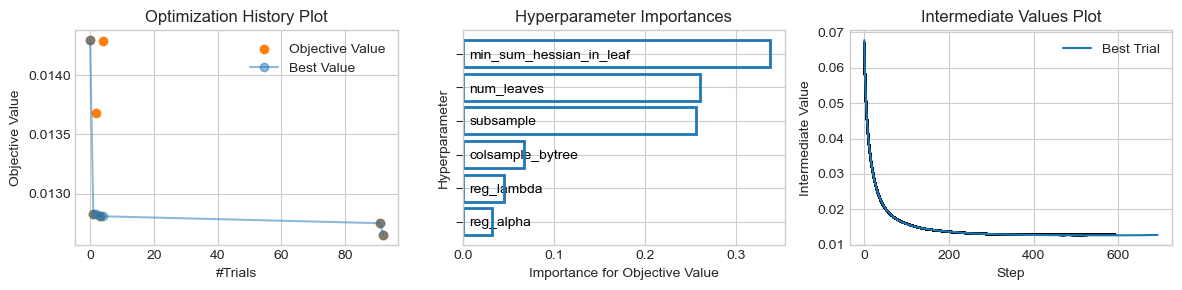

In [21]:
def Verstack_Optimization_plots(root_tag:str=None):
    P = plotting.Verstack_train_plots()
    fig = plt.figure(figsize=(12,3))
    P.plot_optimization_history(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=131)
    P.plot_param_imp(Storage.read_pd(key=f"{root_tag}/tuner_param_imp"),fig=fig,placement=132)
    P.plot_intermediate(Storage.read_pd(key=f"{root_tag}/tuner"),fig=fig,placement=133)
    plt.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{root_tag}__optimization",bbox_inches = 'tight')
    plt.show()

Verstack_Optimization_plots(root_tag='BDT_SB_iter2')


In [9]:
def one_BDT_predicter(Storage,X_target=None,root_tag:str = ''):
    X = X_target.copy()
    XX = X_target.copy()
    
    model = Storage.load_lgbm(key=f"{root_tag}/model")
    feat_idx = model.feature_name()
    X=X[feat_idx]

    X_scaled = Utils.pd_scale(Storage,X, root_tag= root_tag)
    BDT_scores = model.predict(X_scaled.reindex(columns=feat_idx))

    XX[f"P_{root_tag}"] = BDT_scores
    
    return XX

    

In [10]:
BDT_SB_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SB_splits['X_test'],root_tag='BDT_SB')
Sig_vs_BKG_SB_MC_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SB_MC_test ,root_tag='BDT_SB')

#BDT_SB_iter2_test=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SB_splits['X_test'],root_tag='BDT_SB_iter2')
#Sig_vs_BKG_SB_MC_test_iter2=one_BDT_predicter(Storage,X_target = Sig_vs_BKG_SB_MC_test ,root_tag='BDT_SB_iter2')

ValueError: X has 414 features, but RobustScaler is expecting 410 features as input.

In [33]:
from typing import Optional
class plot_response():
    def __init__(self, input_data: pd.core.frame.DataFrame = None, threshold: Optional[float]=None, root_tag:str='BDT1',test_data:bool=False,MC_TEST:bool = False):
        self.input_data = input_data
        self.root_tag = root_tag
        self.test_data = test_data
        self.MC_TEST = MC_TEST

        if (threshold== None) or ((threshold >= 0) and (threshold <= 1)):
            self.threshold = threshold
        else:
            self.threshold = None
            print(f"Threshold/cut were exceeting allowed range which are [0,1], threshold/cut is set to 'None'")

        needed_columns = [f"P_{root_tag}"]
        assert set(needed_columns) == set([i for i in needed_columns if i in list(input_data.columns)]), f"The following columns are not in the input data:\n{[i for i in needed_columns if i not in list(input_data.columns)]}"
        
    def plot_descision_scores(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None, legend1:str = "Signal", legend2:str = "Background"):
        PData = self.input_data

        if self.test_data == False:
            PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

        plot_data = PData.eval(f"P_{self.root_tag}")

        if self.MC_TEST != False:
            signal_truth_mask = (PData.info_truth_matching == 1)
            data_truth_mask = (PData.info_truth_matching == 0)
        else:
            signal_truth_mask = (PData.label == 1)
            data_truth_mask = (PData.label == 0)

        x_range = (logit(PData.eval(f"P_{self.root_tag}")).min(), logit(PData.eval(f"P_{self.root_tag}")).max())
        bins = 100
        bindwidth = (x_range[1]-x_range[0])/bins
        bindwidth_str = str(float(f"{bindwidth:.1g}")).split('.')[0] if float(str(float(f"{bindwidth:.1g}")).split('.')[-1]) == 0 else str(float(f"{bindwidth:.1g}"))
        ax_scores = fig.add_subplot(placemenent)
        c1,_,_ =ax_scores.hist(logit(plot_data[data_truth_mask]), bins=bins, range=x_range,alpha=0.65,edgecolor="k",label=legend1, density=True,log=True)
        c2,c__2,_ =ax_scores.hist(logit(plot_data[signal_truth_mask]), bins=bins, range=x_range, alpha=0.65,edgecolor="k",label=legend2, density=True,log=True)
        if self.threshold != None:
            ax_scores.vlines(logit(self.threshold),0,max(c1+c2),color='black',linestyle=':',label=f"Descision Score Cut: {self.threshold:.3f} | Logit: {logit(self.threshold):.3f}")

        if title != None:
            ax_scores.set_title(title)
        ax_scores.set_ylim(0,max(c1+c2)*100)
        ax_scores.set_xlabel('Probability (Logit Transformed)',loc='right')
        ax_scores.set_ylabel(f"Density / ({bindwidth_str})",loc='top')
        ax_scores.legend(loc = 'upper right', frameon=True)

    def Plot_efficiency_rejection(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None,y_range:tuple=(0,1),legend1:str = "Signal", legend2:str = "Background"):
        PData = self.input_data

        if self.test_data == False:
            PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

        plot_data = PData.eval(f"P_{self.root_tag}")
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


        if self.MC_TEST != False:
            signal_truth_mask = (PData.info_truth_matching == 1)
            data_truth_mask = (PData.info_truth_matching == 0)
        else:
            signal_truth_mask = (PData.label == 1)
            data_truth_mask = (PData.label == 0)

        hist_eff = []
        hist_rej = []

        lin_space_range = np.linspace(0,1,1001)

        for cut in lin_space_range:
            hist_eff.append(len(plot_data[signal_truth_mask][(plot_data[signal_truth_mask] > cut)]) / len(plot_data[signal_truth_mask]))
            hist_rej.append(1-len(plot_data[data_truth_mask][(plot_data[data_truth_mask] > cut )]) / len(plot_data[data_truth_mask]))

        ax_eff = fig.add_subplot(placemenent)
        plot_eff = ax_eff.plot(lin_space_range,hist_eff,label=legend1 +'(Effeciency)',color=cycle[0])

        if self.threshold != None:
            plot_thres = ax_eff.plot([self.threshold,self.threshold],[0,1],color='black',linestyle=':',label=f"Descision Score Cut: {self.threshold:.3f} | Logit: {logit(self.threshold):.3f}")


        ax_eff_y= ax_eff.twinx()

        ax_eff.set_xlabel('Probability',loc='right')
        ax_eff.set_ylabel('Efficiency',loc='top',color=cycle[0])
        ax_eff_y.set_ylabel('Rejection',loc='top',color=cycle[1])
        
        ax_eff_y.set_ylim(y_range)
        ax_eff_y.set_yticks(np.linspace(y_range[0],y_range[1],5))
        ax_eff_y.tick_params(axis='y', labelsize = 8)


        ax_eff.set_ylim(0,1)
        ax_eff.set_yticks(np.linspace(0,1,5))

        plot_rej = ax_eff_y.plot(lin_space_range,hist_rej,label=legend2+'(Rejection)',color=cycle[1])

        if title != None:
            ax_eff.set_title(title)
        
        leg = plot_eff + plot_rej + plot_thres
        labs = [l.get_label() for l in leg]


        ax_eff.legend(leg,labs,frameon=True,loc='lower center')

    def plot_roc_curve(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None):

        PData = self.input_data
        
        if self.test_data == False:
            PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

        plot_data = PData.eval(f"P_{self.root_tag}")
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        if self.MC_TEST != False:
            signal_truth_mask = (PData.info_truth_matching == 1)
            data_truth_mask = (PData.info_truth_matching == 0)
            y_truth = PData.info_truth_matching
        else:
            signal_truth_mask = (PData.label == 1)
            data_truth_mask = (PData.label == 0)
            y_truth = PData.label

        ax_roc = fig.add_subplot(placemenent)

        fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(plot_data))                 # False/True Positive Rate for our model
        auc_score = metrics.auc(fpr,tpr) 
        if self.threshold != None:
            tpr_thres=(sum(map(lambda x : x>self.threshold, plot_data[signal_truth_mask])))/len(plot_data[signal_truth_mask])
            fpr_thres=(sum(map(lambda x : x>self.threshold, plot_data[data_truth_mask])))/len(plot_data[data_truth_mask])

        ax_roc.plot(fpr, tpr, label=f'Area Under Curve (AUC) score: {auc_score:5.3f}',color=cycle[0])
        if self.threshold != None:
            ax_roc.scatter(fpr_thres,tpr_thres,s=40, color=cycle[0],label='Cut on ROC curve')

        prec, recall, _ = metrics.precision_recall_curve(list(y_truth), list(plot_data)) 
        if self.threshold != None:
            precision_thres = metrics.precision_score(list(y_truth), list(plot_data > self.threshold))
            recall__thres = metrics.recall_score(list(y_truth), list(plot_data > self.threshold))
        AP=metrics.average_precision_score(list(y_truth), list(plot_data))

        ax_roc.plot(recall, prec, label=f'Average Precision (AP) score: {AP:5.3f}',color=cycle[1])
        if self.threshold != None:
            ax_roc.scatter(recall__thres,precision_thres,s=40, color=cycle[1],label='Cut on Precision-Recall Curve')

        if title != None:
            ax_roc.set_title(title)                  
        ax_roc.set_xlabel('False Postive Rate: '+r'$\frac{\mathrm{False Positive}}{\mathrm{Actual Negative}}$',loc='right',color=cycle[0])
        ax_roc.set_ylabel('True Positive Rate: '+r'$\frac{\mathrm{True Positive}}{\mathrm{True Positive}+}$',loc='top',color=cycle[0])

        ax_roc_x, ax_roc_y=ax_roc.twiny(), ax_roc.twinx()
        ax_roc_x.set_xticks([]), ax_roc_y.set_yticks([])
        ax_roc_x.grid(False),  ax_roc_y.grid(False)
        ax_roc_x.set_xlabel('Recall: '+r'$\frac{\mathrm{True Positive}}{\mathrm{Actual Positive}}$',loc='right',color=cycle[1])
        ax_roc_y.set_ylabel('Precision: '+r'$\frac{\mathrm{True Positive}}{\mathrm{Predicted Positive}}$',loc='top',color=cycle[1])

        ax_roc.legend(frameon=True,loc='lower center')

    def plot_confusionmatrix_3x3(self,fig:mpl.figure.Figure=None,placemenent:int=131, title:str=None,legend1:str="Signal", legend2:str="Background"):
        if self.threshold != None:
            PData = self.input_data

            if self.test_data == False:
                PData = PData.sort_values(f"P_BDT_min").groupby(['info_event_number']).tail(1).sort_index()

            plot_data = PData.eval(f"P_{self.root_tag}")
            #P_Bd_BdBar=pd.concat([PData.eval(f"P_{self.root_tag}_Bd"),PData.eval(f"P_{self.root_tag}_BdBar")],axis=1)
            cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


            if self.MC_TEST != False:
                signal_truth_mask = (PData.info_truth_matching == 1)
                y_truth = PData.info_truth_matching * ~(signal_truth_mask) + 1 * signal_truth_mask
            else:
                signal_truth_mask = (PData.label == 1)
                y_truth = PData.label * ~(signal_truth_mask) + 1 * signal_truth_mask

            y_predict  = np.array([1 if pred > self.threshold else 0 for pred in plot_data])
            #y_predict[(y_predict==1)]=np.argmax(P_Bd_BdBar.values[(y_predict==1)],axis=1)+1
            
            ax_conf = fig.add_subplot(placemenent)
            cf_matrix = metrics.confusion_matrix(list(y_truth), list(y_predict)) 
            percen_matrix = metrics.confusion_matrix(list(y_truth), list(y_predict), normalize='pred') 
            group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
            group_percentages = ["{0:.2%}".format(value) for value in percen_matrix.flatten()]

            #labels = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]).reshape(2,2)
            labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]).reshape(2,2)
            ax_conf = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',cbar=False)
            ax_conf.set(xlabel='Predicted Values',ylabel='Actual Values')
            ax_conf.xaxis.set_ticklabels([legend2,legend1])
            ax_conf.yaxis.set_ticklabels([legend2,legend1])


            if title != None:
                ax_conf.set_title(title)
        else:
            print('Threshold/cut is needed for the plotting of a confusion matrix.')

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

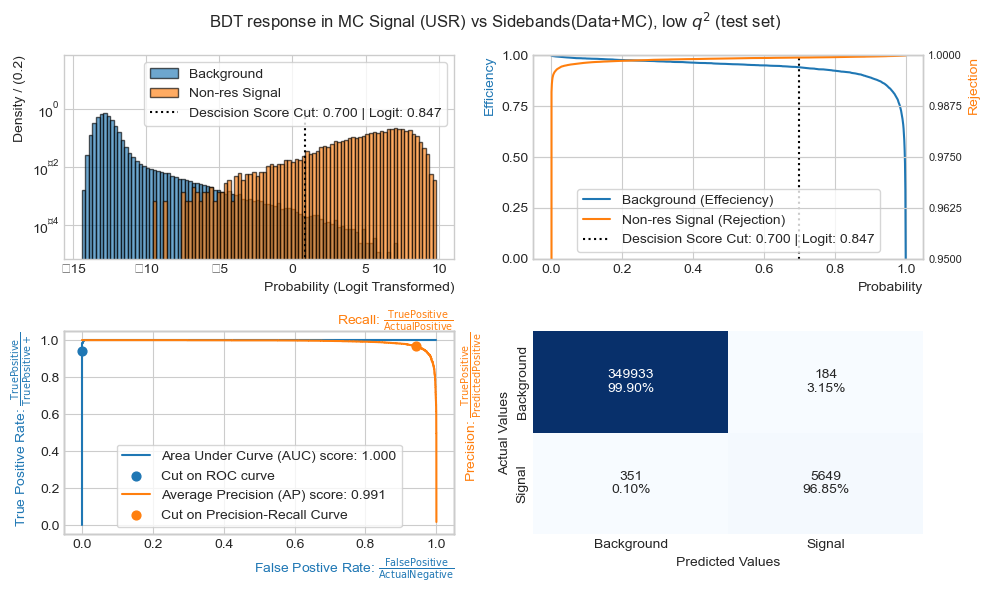

In [34]:
def MC_Sig_Vs_Bkg_SB_response_curve(tag='BDT_SB'):
    #P = plotting.plot_response(input_data=X_test_BDT1,threshold=0.7,root_tag='BDT1',test_data = True)
    P = plot_response(input_data=eval(f"{tag}_test"),threshold=0.7,root_tag=tag,test_data = True)
    fig = plt.figure(figsize=(10,6))
    title=''
    P.plot_descision_scores(fig=fig,placemenent=221,title=title,legend1='Background',legend2='Non-res Signal')
    title=''
    P.Plot_efficiency_rejection(fig=fig,placemenent=222,title=title,y_range=(0.95,1),legend2='Non-res Signal ',legend1='Background ')
    P.plot_roc_curve(fig=fig,placemenent=223)
    P.plot_confusionmatrix_3x3(fig=fig,placemenent=224,legend1='Signal',legend2='Background')
    main_title = "BDT response in MC Signal (USR) vs Sidebands(Data+MC), low $q^2$ (test set)"
    fig.suptitle(main_title)
    fig.tight_layout()
    plt.savefig(config['PATHS']['figure_save']+f"{tag}_test",bbox_inches = 'tight')

    plt.show()
    
MC_Sig_Vs_Bkg_SB_response_curve(tag='BDT_SB')

In [166]:
import sklearn.inspection
from sklearn import preprocessing, model_selection, metrics

class Feature_Importance_plots():
    def __init__(self,N:int=None):
        self.N = N

    def plot_shap(self,fig,placemenent:int,importance_data1=None,importance_data2=None, label1:str =None,label2:str=None):

        ax_shap = fig.add_subplot(placemenent)

        P1 = importance_data1
        if (importance_data2).all() == None:
            P2 = P1
        else:
            P2 = importance_data2.reindex(P1.index)

        if self.N != None:
            P1 = P1.iloc[len(P1)-self.N:]
            P2 = P2.iloc[len(P2)-self.N:]

        x = np.arange(len(P1))
        width = 0.4
      
        ax_shap.barh(x+width/2, P1.values, width,label=label1,alpha=1)
        if (importance_data2 != None).all():
            ax_shap.barh(x-width/2, P2.values, width,label=label2,alpha=1)
        ax_shap.set(title='SHAP Feature Importance',xlabel='mean(|SHAP| value)\n(average impact on model output magnitude)')
        ax_shap.set(yticks=x, yticklabels=list(P1.index), ylim=[2*width - 1-width, len(P1)])
        ax_shap.legend(loc = 'lower right', framealpha =0.95)    
        ax_shap.tick_params(axis='y', which='major', labelsize=7)

    def plot_permute(self,fig=None,placemenent=132,importance_data1=None,importance_data2=None, label1:str =None,label2:str=None):
        ax_permute = fig.add_subplot(placemenent)

        P1 = importance_data1
        if (importance_data2 == None):
            P2 = P1
        else:
            P2 = importance_data2.reindex(P1.index)

        if self.N != None:
            P1 = P1.iloc[len(P1)-self.N:]
            P2 = P2.iloc[len(P2)-self.N:]

        x = np.arange(len(P1))
        width = 0.4
      
        ax_permute.barh(x+width/2, P1.values, width,label=label1,alpha=1)
        if (importance_data2 != None):
            ax_permute.barh(x-width/2, P2.values, width,label=label2,alpha=1)
        ax_permute.set(title='Permutated Feature Importance',xlabel='Relative importance')
        ax_permute.set(yticks=x, yticklabels=list(P1.index), ylim=[2*width - 1-width, len(P1)])
        ax_permute.legend(loc = 'lower right', framealpha =0.95)    
        ax_permute.tick_params(axis='y', which='major', labelsize=7)  

    def plot_native(self,fig=None,placemenent=133,importance_data=None):
        ax_native = fig.add_subplot(placemenent)
        native = importance_data

        if self.N != None:
            native = native.iloc[len(native)-self.N:]

        x = np.arange(len(native))
        width = 0.4
        ax_native.barh(x, native.values)
        ax_native.set(yticks=x, yticklabels=list(native.index), ylim=[2*width - 1-width, len(native)])
        ax_native.set(title='LightGBM Feature Importance',xlabel='Impact on model (Native lightGBM)')
        ax_native.tick_params(axis='y', which='major', labelsize=7)


In [29]:
import sklearn.inspection
from sklearn import preprocessing, model_selection, metrics

class feature_importance:
    def __init__(self,data:pd.DataFrame, root_tag:str):
        self.data = data.copy()
        self.root_tag = root_tag
        self.lgbm_model = None
        self.features = None
        self.load_lightgbm_model_and_set_features()
        self.rets = pd.DataFrame(index = self.features)

    def load_lightgbm_model_and_set_features(self) -> None:
        self.lgbm_model = Storage.load_lgbm(key=f"{self.root_tag}/model")
        self.features = list(self.lgbm_model.feature_name())

    def SHAP(self,X_data:pd.core.frame.DataFrame, label:str) -> None:
        print(f'Init SHAP importances ({label})...')

        X_scaled = Utils.pd_scale(Storage,X_data.copy()[self.features], root_tag= self.root_tag)
        lgbm_shap = self.lgbm_model.predict(X_scaled.reindex(columns=self.features), pred_contrib=True)
        df = pd.DataFrame(columns=['SHAP_'+label],index= self.features, data= np.abs(lgbm_shap[:,:-1]).mean(0))
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with SHAP importances')
    
    def Native_lgbm(self, label:str) -> None:
        print(f'Init Native LGBM importances ({label})...')
        
        native_importance = self.lgbm_model.feature_importance()
        native_indices = np.argsort(native_importance)
        Native_importance = pd.DataFrame({'features': np.array(self.features)[native_indices][::-1], 'native_values': native_importance[native_indices][::-1]})
        
        df = pd.DataFrame(columns=['Native_'+label],index= self.features, data= native_importance)
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Native LGBM importances')

    def Permutation(self,X_data:pd.core.frame.DataFrame, y_data:pd.core.frame.DataFrame, label:str, scorer:sklearn.metrics._scorer._PredictScorer, N_repeats:int) -> None:
        print(f'Init Permutation importances ({label})...')
        AUC_score=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score,greater_is_better=True)
        RMSE_score = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,squared=False,greater_is_better=False)

        PERM_score = sklearn.inspection.permutation_importance(self.lgbm_model, X_data.copy()[self.features], y_data.copy(), n_repeats=N_repeats, random_state=42,n_jobs=1,scoring=scorer)
        df = pd.DataFrame(columns=['perm_'+label],index= self.features, data= PERM_score.importances_mean)
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Permutation importances.')

    def permutation_importance(self,X_data:pd.DataFrame,y_data:pd.DataFrame,label:str, scorer, N_repeats:int=1, N_jobs:int = 1):
        print(f'Init Permutation importances ({label})...')

        #X_scaled = Utils.pd_scale(Storage,X_data, root_tag= self.root_tag)
        BDT_scores = self.lgbm_model.predict(X_data.reindex(columns=self.features))
        original_score = scorer(y_data,BDT_scores)

        importances = {'feature': [], f"perm_{label}": []}

        # For each feature
        for feature in self.features:
            mean = []
            for i in range(5):
            # Create a copy of the test set with the current feature shuffled
                X_test_shuffled = X_data.copy()
                X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature])
                
                BDT_scores = self.lgbm_model.predict(X_test_shuffled)

                # Calculate the score of the shuffled test set
                shuffled_score = scorer(y_data,BDT_scores)
                
                # Calculate the feature importance as the difference in accuracy
                mean.append(shuffled_score - original_score)

            feature_importance = np.mean(np.array(mean))
            importances[f"perm_{label}"].append(feature_importance)
            importances['feature'].append(feature)


        df = pd.DataFrame(importances)
        df = df.set_index('feature')
        self.rets = pd.concat([self.rets,df],axis=1)
        print('Done with Permutation importances.')

    def get_Frame(self) -> pd.DataFrame:
        return self.rets

def AUC_score(y_truth, y_pred):
    fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(y_pred))                 # False/True Positive Rate for our model
    auc_score = metrics.auc(fpr,tpr) 
    return auc_score

if __name__ == "__main__":

    get_importance = feature_importance(data=BDT_SB_test,root_tag='BDT_SB')
    get_importance.Native_lgbm(label='test')
    get_importance.SHAP(X_data=Sig_vs_BKG_SB_splits['X_train_scaled'].sample(200000),label='train')
    get_importance.SHAP(X_data=Sig_vs_BKG_SB_splits['X_test_scaled'].sample(200000),label='test')
    get_importance.permutation_importance(Sig_vs_BKG_SB_splits['X_test_scaled'],Sig_vs_BKG_SB_splits['y_test'],scorer=AUC_score,label='test')

    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_train_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_train'][:100],label='train',scorer=AUC_score,N_repeats=10)
    #get_importance.Permutation(X_data=Sig_vs_BKG_SB_splits['X_test_scaled'][:100],y_data=Sig_vs_BKG_SB_splits['y_test'][:100],label='test',scorer=AUC_score,N_repeats=10)

feature_imp_pd = get_importance.get_Frame()

Init Native LGBM importances (test)...
Done with Native LGBM importances
Init SHAP importances (train)...
Done with SHAP importances
Init SHAP importances (test)...
Done with SHAP importances
Init Permutation importances (test)...
Done with Permutation importances.


In [30]:
Storage.write_pd(key='BDT_SD_all_feature_importance', df=feature_imp_pd, overwrite=False)

In [164]:
feature_imp_pd = Storage.read_pd('BDT_SD_all_feature_importance')

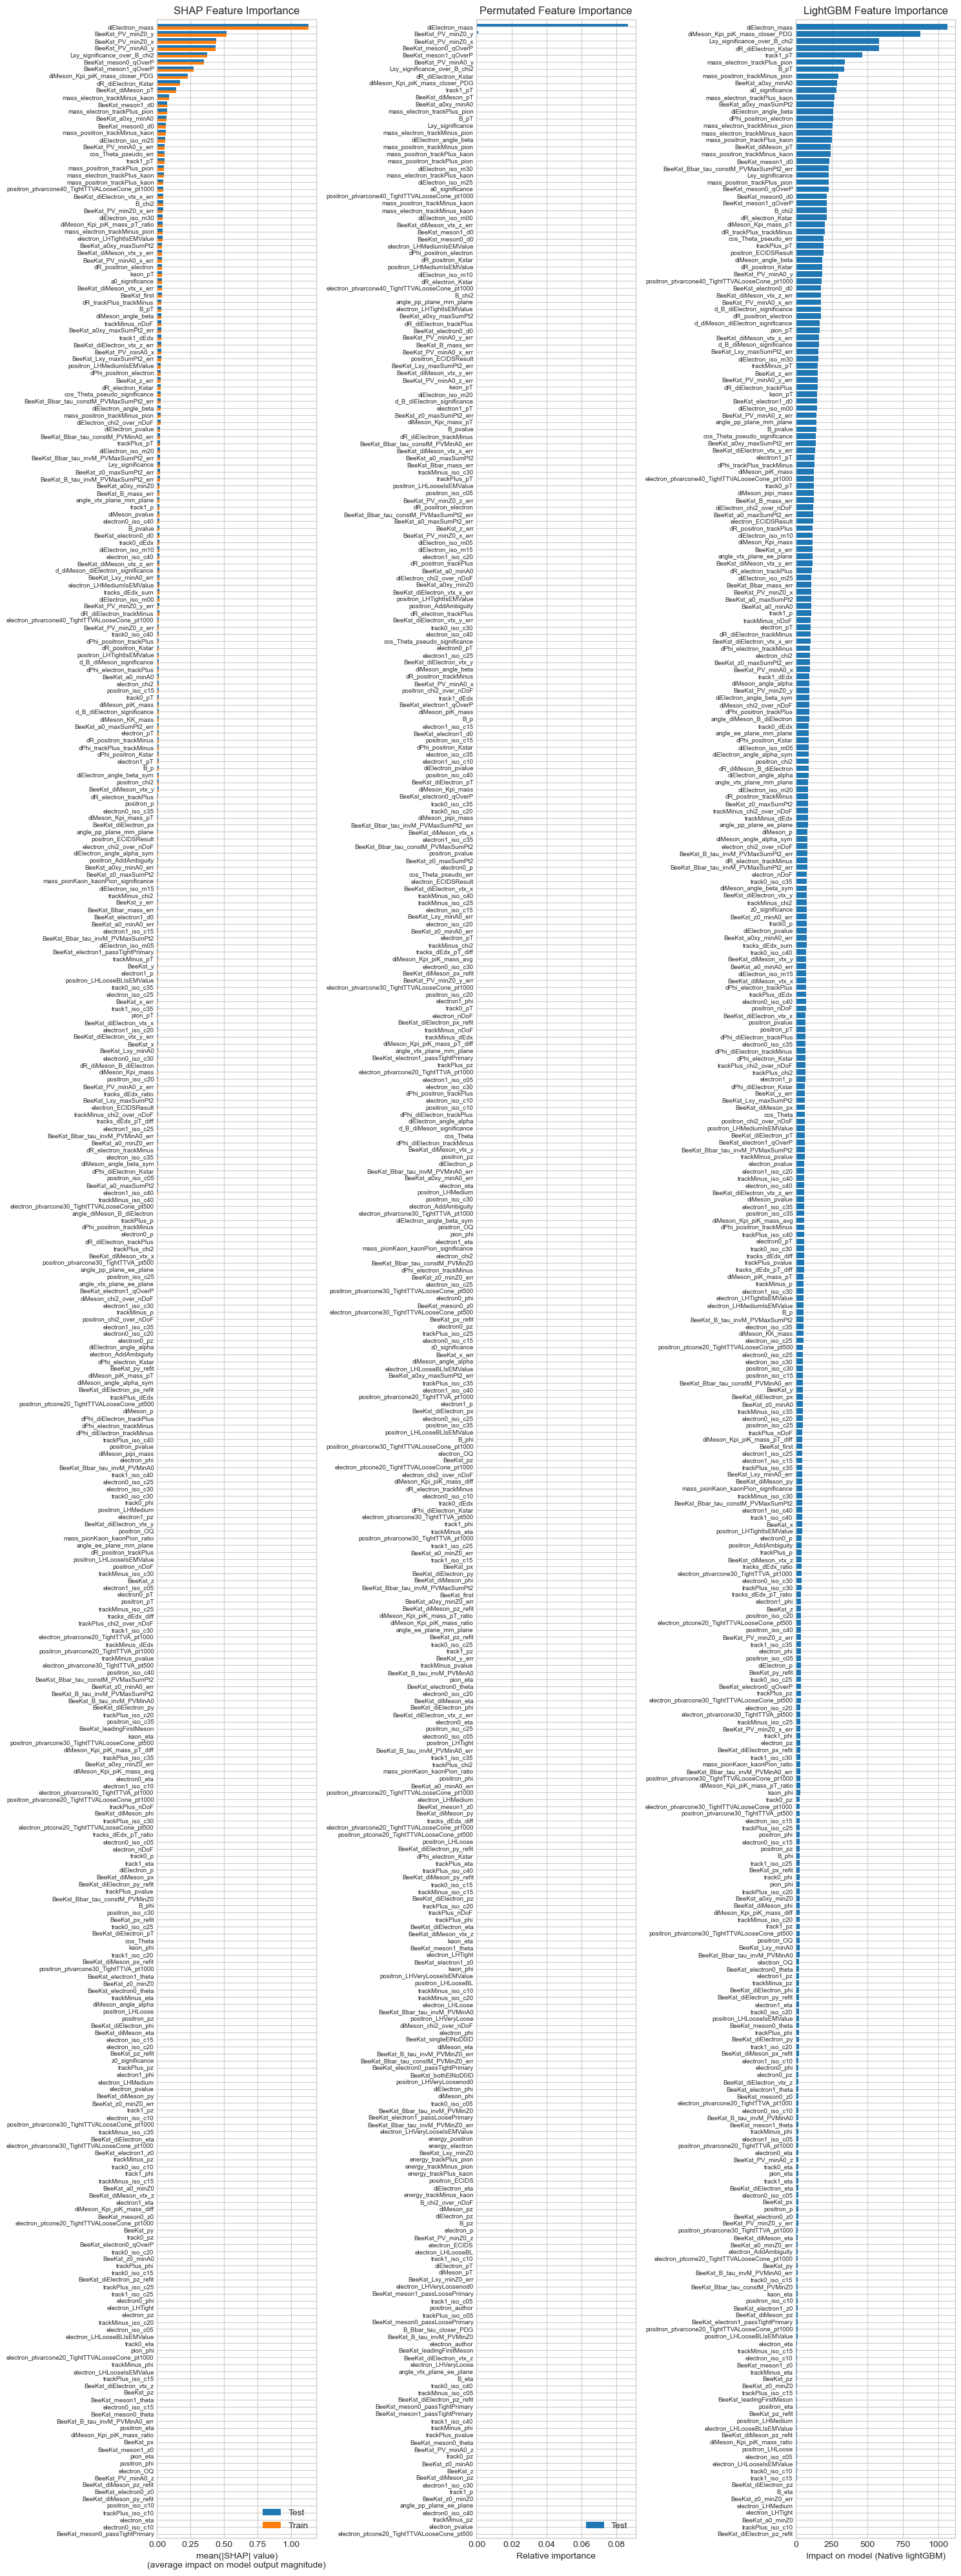

In [167]:



def feature_importance_plots():

    P=Feature_Importance_plots(N=356)

    fig = plt.figure(figsize=(15,40))
    P.plot_shap(fig=fig,placemenent=131,importance_data1= feature_imp_pd.SHAP_test.sort_values(), importance_data2 = feature_imp_pd.SHAP_train.sort_values(), label1 = 'Test', label2 = 'Train')

    P.plot_permute(fig=fig,placemenent=132,importance_data1= (-1*feature_imp_pd.perm_test).sort_values(), label1 = 'Test', label2 = 'Train')
    P.plot_native(fig=fig,placemenent=133,importance_data = feature_imp_pd.Native_test.sort_values())
    #P.plot_neg_permute(fig=fig,placemenent=133)
    plt.tight_layout()
    #plt.savefig(f"figures/{root_tag}_Feature_importances.pdf")
    plt.show()

feature_importance_plots()



In [ ]:
from multiprocess import Pool
N_PROCESS=multiprocessing.cpu_count()-10
N_SIMUL = 100

def for_MP(j):
    return fit_bootstraped(accept_reject_func,N_bootstrap=N_SIMUL,bound=total_fit_config['xrange'],seed=j)

if __name__ ==  '__main__': 
    with Pool() as pool:
        MP_result = pool.map(for_MP, range(N_PROCESS))

In [58]:
['BeeKst_meson1_qOverP','dR_positron_electron','BeeKst_meson0_qOverP','BeeKst_PV_minA0_y','BeeKst_PV_minZ0_y','BeeKst_PV_minZ0_x', 'BeeKst_PV_minA0_x', 'BeeKst_PV_minZ0_x_err','BeeKst_PV_minZ0_y_err','BeeKst_PV_minZ0_z_err','BeeKst_PV_minA0_x_err','BeeKst_PV_minA0_y_err','BeeKst_PV_minA0_z_err']

best_SHAP_test = set(feature_imp_pd.sort_values(by='SHAP_test',ascending=False)[:60].index)
best_SHAP_train = set(feature_imp_pd.sort_values(by='SHAP_train',ascending=False)[:60].index)
best_Native_test = set(feature_imp_pd.sort_values(by='Native_test',ascending=False)[:60].index)
best_perm_test = set(feature_imp_pd.sort_values(by='perm_test',ascending=True)[:60].index)

len(((best_SHAP_test.intersection(best_SHAP_train)).intersection(best_Native_test)).intersection(best_perm_test))


best_SHAP_test = set(feature_imp_pd.sort_values(by='SHAP_test',ascending=False)[:20].index)
best_SHAP_train = set(feature_imp_pd.sort_values(by='SHAP_train',ascending=False)[:20].index)
best_Native_test = set(feature_imp_pd.sort_values(by='Native_test',ascending=False)[:20].index)
best_perm_test = set(feature_imp_pd.sort_values(by='perm_test',ascending=True)[:20].index)
best_union = ((best_SHAP_test.union(best_SHAP_train)).union(best_Native_test)).union(best_perm_test)

best_union = list(feature_imp_pd.sort_values(by='perm_test',ascending=True)[:20].index)
print(list(best_union))
print(len(list(best_union)))


['dR_diElectron_Kstar', 'dPhi_positron_electron', 'BeeKst_y', 'Lxy_significance_over_B_chi2', 'BeeKst_a0_maxSumPt2', 'diElectron_iso_m00', 'diMeson_Kpi_piK_mass_closer_PDG', 'BeeKst_diElectron_vtx_y_err', 'BeeKst_diElectron_pT', 'track1_pT', 'BeeKst_diElectron_vtx_x_err', 'BeeKst_diMeson_pT', 'positron_OQ', 'positron_ptvarcone40_TightTTVALooseCone_pt1000', 'tracks_dEdx_sum', 'cos_Theta', 'BeeKst_diElectron_vtx_z_err', 'electron_ptvarcone40_TightTTVALooseCone_pt1000', 'electron1_pT', 'BeeKst_Bbar_tau_constM_PVMinA0_err']
20


In [27]:
import multiprocess

def double(a):
    return a * 2, a

def driver_func():
    PROCESSES = 2
    rets = pd.DataFrame()
    with multiprocess.Pool(PROCESSES) as pool:
        params = [(1, ), (2, ), (3, ), (4, ),(5,)]
        results = [pool.apply_async(double, p) for p in params]

        print([r.get() for r in results])

        for r in results:
            print('\t', r.get(),flush=True)



In [35]:
[(i,) for i in range(2)]

[(0,), (1,)]

In [44]:
import multiprocess
from functools import partial

class feature_importance2:
    def __init__(self,X_data:pd.DataFrame,y_data:pd.DataFrame, root_tag:str,scorer):
        self.X_data = X_data.copy()
        self.y_data = y_data.copy()
        self.root_tag = root_tag
        self.lgbm_model = None
        self.features = None
        self.Perm_original_score = None
        self.load_lightgbm_model_and_set_features()
        self.rets = pd.DataFrame(index = self.features)
        self.scorer_func = scorer
        self.Original_permutation_importance()

    def load_lightgbm_model_and_set_features(self) -> None:
        self.lgbm_model = Storage.load_lgbm(key=f"{self.root_tag}/model")
        self.features = list(self.lgbm_model.feature_name())

    def Original_permutation_importance(self):
        BDT_scores = self.lgbm_model.predict(self.X_data.reindex(columns=self.features))
        self.Perm_original_score = self.scorer_func(self.y_data,BDT_scores)
        
    def permutation_importance(self,N_repeats,N_jobs):
        print('start')
        with multiprocess.Pool(N_jobs) as pool:
            params = [(f,self.X_data,self.y_data,self.Perm_original_score,self.lgbm_model,self.scorer_func,N_repeats,) for f in self.features[:2]]
            results = [pool.apply_async(calc_importance, p) for p in params]

            print([r.get() for r in results])




    def driver_func(self,N_jobs:int=1,N_repeats:int=1,label:str='test'):
        self.X_data.to_pickle('_X_data.pkl')
        self.y_data.to_pickle('_y_data.pkl')
        with open("model.txt", "w") as text_file:
            text_file.write(Storage.load_lgbm(key=f"{self.root_tag}/model").model_to_string())
        
        PROCESSES = N_jobs
        with multiprocess.Pool(PROCESSES) as pool:
            #params = [(f,self.Perm_original_score,N_repeats) for f in self.features[:5]]
            #results = [pool.apply_async(double1, p) for p in params]
            params = [f for f in self.features[:3]]

            func = partial(double1, self.Perm_original_score, N_repeats)

            for result in pool.imap(func, params):
                print(f'Got result: {result}', flush=True)
            #result = pool.imap(func, params)

            #print(result)

            #print([r.get() for r in results])
            #for r in results:
            #    print('\t', r.get(),flush=True)
       
#        df = pd.DataFrame(importances)
#        df = df.set_index('feature')
#        self.rets = pd.concat([self.rets,df],axis=1)
#        print('Done with Permutation importances.')

    def get_Frame(self) -> pd.DataFrame:
        return self.rets


def AUC_score(y_truth, y_pred):
    fpr, tpr, _ = metrics.roc_curve(list(y_truth), list(y_pred))                 # False/True Positive Rate for our model
    auc_score = metrics.auc(fpr,tpr) 
    return auc_score

def calc_importance(feature,X_data,y_data,original_score,model,score_func,N_repeats):
    print(feature)
    mean = []
    for i in range(N_repeats):
    # Create a copy of the test set with the current feature shuffled
        X_test_shuffled = X_data.copy()
        X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature])
        
        BDT_scores = model.predict(X_test_shuffled)

        # Calculate the score of the shuffled test set
        shuffled_score = score_func(y_data,BDT_scores)
        
        # Calculate the feature importance as the difference in accuracy
        mean.append(shuffled_score - original_score)

    feature_importance = np.mean(np.array(mean))
    print(feature, feature_importance)
    return feature, feature_importance



In [43]:
with open("model.txt", "w") as text_file:
    text_file.write(Storage.load_lgbm(key=f"{'BDT_SB'}/model").model_to_string())



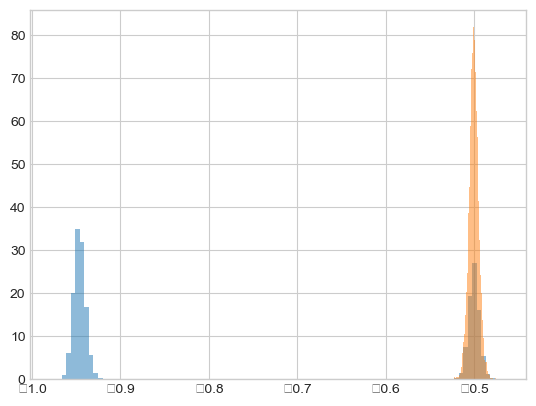

In [175]:

#['diElectron_mass', 'BeeKst_PV_minZ0_y', 'BeeKst_PV_minA0_y', 'BeeKst_PV_minZ0_x']
plt.hist(Sig_vs_BKG_SB_splits['X_train'].BeeKst_PV_minA0_y[(Sig_vs_BKG_SB_splits['X_train'].label==0)],bins=100,density=True,alpha=0.5);
plt.hist(Sig_vs_BKG_SB_splits['X_train'].BeeKst_PV_minA0_y[(Sig_vs_BKG_SB_splits['X_train'].label==1)],bins=100,density=True,alpha=0.5);

(array([8.30922e+05, 4.00000e+00, 4.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.00000e+00]),
 array([-3.18084230e-01,  3.24894447e+01,  6.52969736e+01,  9.81045025e+01,
         1.30912031e+02,  1.63719560e+02,  1.96527089e+02,  2.29334618e+02,
         2.62142147e+02,  2.94949676e+02,  3.27757205e+02]),
 <BarContainer object of 10 artists>)

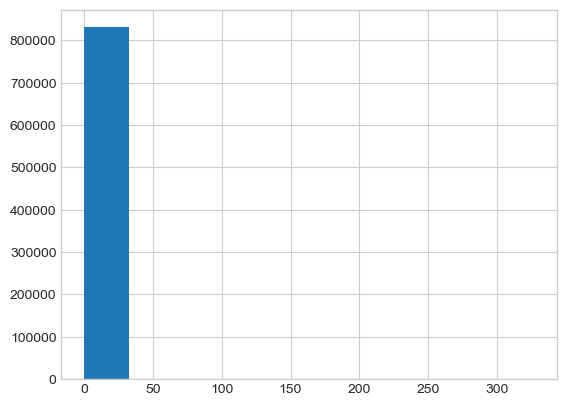

In [38]:
plt.hist(Sig_vs_BKG_SB_splits['X_train_scaled'].electron_ptcone20_TightTTVALooseCone_pt500)

In [68]:
Sig_vs_BKG_SR = pd.concat([SIG_MC,BKG_SR,BKG_MC.query(Utils.selection_cuts()['MC2'])])
Sig_vs_BKG_SR_MC_test = pd.concat([MC_tests['SR'],MC_tests['MC']])
Sig_vs_BKG_SR_splits = train_test_split_stratified(Sig_vs_BKG_SR)

Utils.fit_scaler_to_train(Storage,Sig_vs_BKG_SR_splits['X_train'][features],root_tag='BDT_SR')
Sig_vs_BKG_SR_splits['X_train_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SR_splits['X_train'][features], root_tag= 'BDT_SR', target_tag = 'X_train')
Sig_vs_BKG_SR_splits['X_test_scaled'] = Utils.pd_scale(Storage,Sig_vs_BKG_SR_splits['X_test'][features], root_tag= 'BDT_SR', target_tag = 'X_test')


In [11]:
Sig_vs_BKG_SR_splits['X_train_scaled']

BeeKst_a0xy_maxSumPt2  BeeKst_a0xy_maxSumPt2_err  BeeKst_a0xy_minA0  \
0                    0.570555                   0.010978           0.580009   
1                   -0.414003                  -0.816762          -0.409779   
2                   -0.391445                  -0.447873          -0.387101   
3                    0.087762                   0.126643           0.094651   
4                    0.116950                  -0.243653           0.123994   
...                       ...                        ...                ...   
830933               0.047087                   0.213755          -0.087906   
830934              -0.500389                   0.512941          -0.496624   
830935              -0.368749                  -0.174471          -0.364285   
830936              -0.182952                  -1.139615          -0.177501   
830937              -0.508723                  -0.304728          -0.505002   

        BeeKst_a0xy_minA0_err  BeeKst_a0xy_minZ0  BeeKst_a0xy_minZ0_err  \
0                    0.008301           0.579956               0.008305   
1                   -0.817706          -0.409784              -0.817701   
2                   -0.449590          -0.387107              -0.449585   
3                    0.123724           0.094622               0.123728   
4                   -0.245796           0.123963              -0.245792   
...                       ...                ...                    ...   
830933               0.214751          -0.087926               0.214755   
830934               0.509212          -0.496625               0.509217   
830935              -0.176760          -0.364293              -0.176756   
830936              -1.139882          -0.177517              -1.139877   
830937              -0.306744          -0.505003              -0.306739   

        BeeKst_Lxy_maxSumPt2  BeeKst_Lxy_maxSumPt2_err  BeeKst_Lxy_minA0  \
0                  -0.210816                 -0.234788         -0.210656   
1                  -0.078045                 -0.078971         -0.077890   
2                   0.096660                  0.405135          0.096809   
3                   0.018505                 -0.745487          0.018657   
4                  -0.210583                  0.653646         -0.210423   
...                      ...                       ...               ...   
830933             -0.369283                 -0.164612         -0.350708   
830934             -0.537919                 -0.547029         -0.537748   
830935             -0.462095                  0.213240         -0.461927   
830936              0.594082                  4.136986          0.594213   
830937             10.096482                 -0.482467         10.096276   

        BeeKst_Lxy_minA0_err  ...  trackPlus_dEdx  trackMinus_dEdx  \
0                  -0.235006  ...       -0.596425        -0.915555   
1                  -0.079142  ...       -0.226689        -0.329676   
2                   0.405114  ...       -0.414956        -0.864335   
3                  -0.745862  ...       -0.124480         0.122074   
4                   0.653702  ...       -0.571059        -0.048124   
...                      ...  ...             ...              ...   
830933             -0.164821  ...       -0.227615        -0.217657   
830934             -0.547343  ...        0.618753         0.350464   
830935              0.213160  ...       -0.526682        -0.653478   
830936              4.138114  ...        0.053224        -1.031665   
830937             -0.482762  ...        0.915083         0.487307   

        track0_dEdx  track1_dEdx  tracks_dEdx_sum  tracks_dEdx_diff  \
0         -0.935125    -0.580659        -0.844176          0.303450   
1         -0.231801    -0.322844        -0.321166          0.100906   
2         -0.883304    -0.401236        -0.716680          0.426598   
3         -0.128096     0.122532        -0.018159         -0.227983   
4         -0.581210    -0.045265        -0.356049

In [69]:
%%capture --no-stdout

def Run_tuner(X_,y_,Storage=Storage,root_tag='BDT_SR'):

    assert str(type(Storage).__module__) == "Storage.Global", "Input Storage is not a correct global storage initialized from the HDF5_IO-function"

    np.random.seed(42)
    #print(f"Training LGBM with {Storage.read_pd(key=f"{root_tag}/X_train").shape[1]} features")
    tuner = verstack.LGBMTuner(metric = 'log_loss',trials=100, visualization = False, seed = 42,verbosity=1)
    
    tuner.fit(X=X_,y=y_.astype(int).squeeze())

    Storage.write_pd(key=f"{root_tag}/tuner", df = tuner.study.trials_dataframe(attrs=('number', 'value', 'params', 'state','intermediate_values'),multi_index=True),overwrite=True)
    Storage.write_pd(key=f"{root_tag}/tuner_param_imp", df = pd.DataFrame([dict(optuna.importance.get_param_importances(tuner.study).items())]).T.rename(columns={0:'value'}),overwrite=True)
    Storage.save_lgbm(key=f"{root_tag}/model",tuner=tuner, feature_names = list(X_.columns), overwrite=True)

    print('Done with training model')
    return tuner

tuner = Run_tuner(X_=Sig_vs_BKG_SR_splits['X_train_scaled'],y_=Sig_vs_BKG_SR_splits['y_train'],root_tag='BDT_SR_iter2')



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: log_loss 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.014930764735294425
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.013403436166426775
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.01420135444309114
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.013090822209251195
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): log_loss: 0.015036163657796002
 .........

In [70]:
def Data_loader():
    N_times_signal = 4
    print('Loading MC signal..')
    SIG_MC=pd.read_feather(path=config['PATHS']['feather']+ config['train_files']['USR'], columns=None, use_threads=True, storage_options=None)
    SIG_MC = SIG_MC.query(Utils.selection_cuts()['usr_lowq2'])
    SIG_MC.drop(SIG_MC[~((SIG_MC.BeeKst_isTrueNonresBd==1) | (SIG_MC.BeeKst_isTrueNonresBdbar==1))].index,inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBd==1)].index[N_times_signal*config['ML_config']['N_Signal']['Bd']:],inplace=True)
    SIG_MC.drop(SIG_MC[(SIG_MC.BeeKst_isTrueNonresBdbar==1)].index[N_times_signal*config['ML_config']['N_Signal']['BdBar']:],inplace=True)

    label = (SIG_MC.info_sample == 0)*0
    for i in config['labels B_VS_BBar']:
        label += (SIG_MC.info_sample == str(i))*config['labels B_VS_BBar'][str(i)]
    SIG_MC['label'] = label

    return SIG_MC

B_vs_Bbar = Data_loader()

B_vs_Bbar = pd.concat([B_vs_Bbar])
B_vs_Bbar_splits = train_test_split_stratified(B_vs_Bbar)

Utils.fit_scaler_to_train(Storage,B_vs_Bbar_splits['X_train'][features],root_tag='BDT_BBbar')
B_vs_Bbar_splits['X_train_scaled'] = Utils.pd_scale(Storage,B_vs_Bbar_splits['X_train'][features], root_tag= 'BDT_BBbar', target_tag = 'X_train')
B_vs_Bbar_splits['X_test_scaled'] = Utils.pd_scale(Storage,B_vs_Bbar_splits['X_test'][features], root_tag= 'BDT_BBbar', target_tag = 'X_test')

Loading MC signal..


In [71]:
%%capture --no-stdout

def Run_tuner(X_,y_,Storage=Storage,root_tag='BDT_MC'):

    assert str(type(Storage).__module__) == "Storage.Global", "Input Storage is not a correct global storage initialized from the HDF5_IO-function"

    np.random.seed(42)
    #print(f"Training LGBM with {Storage.read_pd(key=f"{root_tag}/X_train").shape[1]} features")
    tuner = verstack.LGBMTuner(metric = 'log_loss',trials=100, visualization = False, seed = 42,verbosity=1)
    
    tuner.fit(X=X_,y=y_.astype(int).squeeze())

    Storage.write_pd(key=f"{root_tag}/tuner", df = tuner.study.trials_dataframe(attrs=('number', 'value', 'params', 'state','intermediate_values'),multi_index=True),overwrite=True)
    Storage.write_pd(key=f"{root_tag}/tuner_param_imp", df = pd.DataFrame([dict(optuna.importance.get_param_importances(tuner.study).items())]).T.rename(columns={0:'value'}),overwrite=True)
    Storage.save_lgbm(key=f"{root_tag}/model",tuner=tuner, feature_names = list(X_.columns), overwrite=True)

    print('Done with training model')
    return tuner

tuner = Run_tuner(X_=B_vs_Bbar_splits['X_train_scaled'],y_=B_vs_Bbar_splits['y_train'],root_tag='BDT_BBbar')


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: log_loss 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.6914608948846072
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.6915619990037566
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.6916613157499334
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.6907442249261927
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): log_loss: 0.6909082460493771
 ..................